In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import Imputer
import math

import copy
import argparse

%matplotlib inline

In [2]:
ames_train = pd.read_csv('./datasets/train.csv')
ames_test = pd.read_csv('./datasets/test.csv')
ames_test_1 = pd.read_csv('./datasets/test.csv')
test_id = ames_test['Id'].to_frame()
Sale = (ames_train['SalePrice'])
print(ames_train.shape)
print(ames_test.shape)
print(Sale.mean())

(2051, 81)
(879, 80)
181469.70160897123


In [ ]:
ames_train.columns

In [ ]:
ames_train.groupby('Street')['SalePrice'].agg(['mean']).sort_values(by='mean', ascending=False)

In [ ]:
Sale = (ames_train['SalePrice'])

def mean_level(df, col, index):
    mean = df.loc[df[col] == index]['SalePrice'].mean()
    return mean

def replace_with_sq_mean(df, col_list, inplace=True):
    df2 = df.copy()
    for col in col_list:
        for (index, val) in df[col].iteritems():
            mean = mean_level(df, col, val)
            df2[col, val] = np.sqrt(mean)
    return df2


In [ ]:
ames_train = replace_with_sq_mean(ames_train, ['MS SubClass',
                                  'MS Zoning', 
                                  'Street',
                                  'Alley', 
                                  'Land Contour', 
                                  'Lot Config', 
                                  'Neighborhood', 
                                  'Condition 1',
                                  'Condition 2',
                                  'Bldg Type',
                                  'House Style',
                                  'Exter Cond', 
                                  'Heating', 
                                  'Exterior 1st', 
                                  'Roof Style',
                                 ])

In [ ]:
ames_test = replace_with_sq_mean(ames_test, ['MS SubClass',
                                  'MS Zoning', 
                                  'Street',
                                  'Alley', 
                                  'Land Contour', 
                                  'Lot Config', 
                                  'Neighborhood', 
                                  'Condition 1',
                                  'Condition 2',
                                  'Bldg Type',
                                  'House Style',
                                  'Exter Cond', 
                                  'Heating', 
                                  'Exterior 1st', 
                                  'Roof Style',
                                 ])

In [ ]:
ames_train.groupby('Neighborhood')['SalePrice'].agg(['mean']).sort_values(by='mean', ascending=False)

In [3]:
# Create Variable for train set
ames_train["EXTcond"] = np.nan
ames_train.loc[(ames_train['Exter Cond'] == 'Ex'), 'EXTcond'] = 10

ames_train.loc[(ames_train['Exter Cond'] == 'TA'), 'EXTcond'] = 7.84

ames_train.loc[(ames_train['Exter Cond'] == 'Gd'), 'EXTcond'] = 7.09

ames_train.loc[(ames_train['Exter Cond'] == 'Fa'), 'EXTcond'] = 4.34

ames_train.loc[(ames_train['Exter Cond'] == 'Po'), 'EXTcond'] = 1.90



               
# Create Variable for test set
ames_test["EXTcond"] = np.nan
ames_test.loc[(ames_test['Exter Cond'] == 'Ex'), 'EXTcond'] = 10

ames_test.loc[(ames_test['Exter Cond'] == 'TA'), 'EXTcond'] = 7.84

ames_test.loc[(ames_test['Exter Cond'] == 'Gd'), 'EXTcond'] = 7.09

ames_test.loc[(ames_test['Exter Cond'] == 'Fa'), 'EXTcond'] = 4.34

ames_test.loc[(ames_test['Exter Cond'] == 'Po'), 'EXTcond'] = 1.90


In [4]:
# Create Variable for train set
ames_train["EXTerior"] = np.nan
ames_train.loc[(ames_train['Exterior 1st'] == 'ImStucc'), 'EXTerior'] = 12

ames_train.loc[(ames_train['Exterior 1st'] == 'Stone'), 'EXTerior'] = 11.84

ames_train.loc[(ames_train['Exterior 1st'] == 'CemntBd'), 'EXTerior'] = 11.15

ames_train.loc[(ames_train['Exterior 1st'] == 'VinylSd'), 'EXTerior'] = 9.99

ames_train.loc[(ames_train['Exterior 1st'] == 'BrkFace'), 'EXTerior'] = 8.84

ames_train.loc[(ames_train['Exterior 1st'] == 'Plywood'), 'EXTerior'] = 7.81

ames_train.loc[(ames_train['Exterior 1st'] == 'HdBoard'), 'EXTerior'] = 7.31

ames_train.loc[(ames_train['Exterior 1st'] == 'WdShing'), 'EXTerior'] = 7.13

ames_train.loc[(ames_train['Exterior 1st'] == 'MetalSd'), 'EXTerior'] = 7.07

ames_train.loc[(ames_train['Exterior 1st'] == 'Wd Sdng'), 'EXTerior'] = 6.55

ames_train.loc[(ames_train['Exterior 1st'] == 'Stucco'), 'EXTerior'] = 6.40

ames_train.loc[(ames_train['Exterior 1st'] == 'BrkComm'), 'EXTerior'] = 6.00

ames_train.loc[(ames_train['Exterior 1st'] == 'AsbShng'), 'EXTerior'] = 4.73

ames_train.loc[(ames_train['Exterior 1st'] == 'CBlock'), 'EXTerior'] = 4.27

ames_train.loc[(ames_train['Exterior 1st'] == 'AsphShn'), 'EXTerior'] = 3.77

               
# Create Variable for test set
ames_test["EXTerior"] = np.nan
ames_test.loc[(ames_test['Exterior 1st'] == 'ImStucc'), 'EXTerior'] = 12

ames_test.loc[(ames_test['Exterior 1st'] == 'Stone'), 'EXTerior'] = 11.84

ames_test.loc[(ames_test['Exterior 1st'] == 'CemntBd'), 'EXTerior'] = 11.15

ames_test.loc[(ames_test['Exterior 1st'] == 'VinylSd'), 'EXTerior'] = 9.99

ames_test.loc[(ames_test['Exterior 1st'] == 'BrkFace'), 'EXTerior'] = 8.84

ames_test.loc[(ames_test['Exterior 1st'] == 'Plywood'), 'EXTerior'] = 7.81

ames_test.loc[(ames_test['Exterior 1st'] == 'HdBoard'), 'EXTerior'] = 7.31

ames_test.loc[(ames_test['Exterior 1st'] == 'WdShing'), 'EXTerior'] = 7.13

ames_test.loc[(ames_test['Exterior 1st'] == 'MetalSd'), 'EXTerior'] = 7.07

ames_test.loc[(ames_test['Exterior 1st'] == 'Wd Sdng'), 'EXTerior'] = 6.55

ames_test.loc[(ames_test['Exterior 1st'] == 'Stucco'), 'EXTerior'] = 6.40

ames_test.loc[(ames_test['Exterior 1st'] == 'BrkComm'), 'EXTerior'] = 6.00

ames_test.loc[(ames_test['Exterior 1st'] == 'AsbShng'), 'EXTerior'] = 4.73

ames_test.loc[(ames_test['Exterior 1st'] == 'CBlock'), 'EXTerior'] = 4.27

ames_test.loc[(ames_test['Exterior 1st'] == 'AsphShn'), 'EXTerior'] = 3.77

In [5]:
# Create Variable for train set
ames_train["Roof_Sty"] = np.nan
ames_train.loc[(ames_train['Roof Style'] == 'Hip'), 'Roof_Sty'] = 5

ames_train.loc[(ames_train['Roof Style'] == 'Shed'), 'Roof_Sty'] = 4.65

ames_train.loc[(ames_train['Roof Style'] == 'Flat'), 'Roof_Sty'] = 4.27

ames_train.loc[(ames_train['Roof Style'] == 'Gable'), 'Roof_Sty'] = 3.82

ames_train.loc[(ames_train['Roof Style'] == 'Mansard'), 'Roof_Sty'] = 3.40

ames_train.loc[(ames_train['Roof Style'] == 'Gambrel'), 'Roof_Sty'] = 3.08

               
# Create Variable for test set
ames_test["Roof_Sty"] = np.nan
ames_test.loc[(ames_test['Roof Style'] == 'Hip'), 'Roof_Sty'] = 5

ames_test.loc[(ames_test['Roof Style'] == 'Shed'), 'Roof_Sty'] = 4.65

ames_test.loc[(ames_test['Roof Style'] == 'Flat'), 'Roof_Sty'] = 4.27

ames_test.loc[(ames_test['Roof Style'] == 'Gable'), 'Roof_Sty'] = 3.82

ames_test.loc[(ames_test['Roof Style'] == 'Mansard'), 'Roof_Sty'] = 3.40

ames_test.loc[(ames_test['Roof Style'] == 'Gambrel'), 'Roof_Sty'] = 3.08

In [6]:
# Create Variable for train set
ames_train["Roof_Sty"] = ''
ames_train.loc[(ames_train['Roof Style'] == '2.5Fin'), 'Roof_Sty'] = 7

ames_train.loc[(ames_train['Roof Style'] == '2Story'), 'Roof_Sty'] = 5.93

ames_train.loc[(ames_train['House Style'] == '2.5Unf'), 'Roof_Sty'] = 5.51

ames_train.loc[(ames_train['House Style'] == '1Story'), 'Roof_Sty'] = 5.17

ames_train.loc[(ames_train['House Style'] == 'SLvl'), 'Roof_Sty'] = 4.78

ames_train.loc[(ames_train['House Style'] == 'SFoyer'), 'Roof_Sty'] = 4.29

               
# Create Variable for test set
ames_test["Roof_Sty"] = ''
ames_test.loc[(ames_test['House Style'] == '2.5Fin'), 'Roof_Sty'] = 7

ames_test.loc[(ames_test['House Style'] == '2Story'), 'Roof_Sty'] = 5.93

ames_test.loc[(ames_test['House Style'] == '2.5Unf'), 'Roof_Sty'] = 5.51

ames_test.loc[(ames_test['House Style'] == '1Story'), 'Roof_Sty'] = 5.17

ames_test.loc[(ames_test['House Style'] == 'SLvl'), 'Roof_Sty'] = 4.78

ames_test.loc[(ames_test['House Style'] == 'SFoyer'), 'Roof_Sty'] = 4.29



In [7]:
# Create Variable for train set
ames_train["ZONE"] = np.nan
ames_train.loc[(ames_train['MS Zoning'] == 'FV'), 'ZONE'] = 10

ames_train.loc[(ames_train['MS Zoning'] == 'RL'), 'ZONE'] = 8.75

ames_train.loc[(ames_train['MS Zoning'] == 'RH'), 'ZONE'] = 6.81

ames_train.loc[(ames_train['MS Zoning'] == 'RM'), 'ZONE'] = 5.91

ames_train.loc[(ames_train['MS Zoning'] == 'C (all)'), 'ZONE'] = 3.57

ames_train.loc[(ames_train['MS Zoning'] == 'I (all)'), 'ZONE'] = 2.64

ames_train.loc[(ames_train['MS Zoning'] == 'A (agr)'), 'ZONE'] = 2.16

               
# Create Variable for test set
ames_test["ZONE"] = np.nan
ames_test.loc[(ames_test['MS Zoning'] == 'FV'), 'ZONE'] = 10

ames_test.loc[(ames_test['MS Zoning'] == 'RL'), 'ZONE'] = 8.75

ames_test.loc[(ames_test['MS Zoning'] == 'RH'), 'ZONE'] = 6.81

ames_test.loc[(ames_test['MS Zoning'] == 'RM'), 'ZONE'] = 5.91

ames_test.loc[(ames_test['MS Zoning'] == 'C (all)'), 'ZONE'] = 3.57

ames_test.loc[(ames_test['MS Zoning'] == 'I (all)'), 'ZONE'] = 2.64

ames_test.loc[(ames_test['MS Zoning'] == 'A (agr)'), 'ZONE'] = 2.16


In [8]:
# Create Variable for train set
ames_train["GarageT"] = np.nan
ames_train.loc[(ames_train['Garage Type'] == 'BuiltIn'), 'GarageT'] = 8

ames_train.loc[(ames_train['Garage Type'] == 'Attchd'), 'GarageT'] = 6.62

ames_train.loc[(ames_train['Garage Type'] == '2Types'), 'GarageT'] = 5.07

ames_train.loc[(ames_train['Garage Type'] == 'Basment'), 'BasQual'] = 4.62

ames_train.loc[(ames_train['Garage Type'] == 'Detchd'), 'GarageT'] = 4.26

ames_train.loc[(ames_train['Garage Type'] == 'no_value_reported'), 'GarageT'] = 3.41

ames_train.loc[(ames_train['Garage Type'] == 'CarPort'), 'GarageT'] = 3.35


               
# Create Variable for test set
ames_test["GarageT"] = np.nan
ames_test.loc[(ames_test['Garage Type'] == 'BuiltIn'), 'GarageT'] = 8

ames_test.loc[(ames_test['Garage Type'] == 'Attchd'), 'GarageT'] = 6.62

ames_test.loc[(ames_test['Garage Type'] == '2Types'), 'GarageT'] = 5.07

ames_test.loc[(ames_test['Garage Type'] == 'Basment'), 'GarageT'] = 4.62

ames_test.loc[(ames_test['Garage Type'] == 'Detchd'), 'GarageT'] = 4.26

ames_test.loc[(ames_test['Garage Type'] == 'no_value_reported'), 'GarageT'] = 3.41

ames_test.loc[(ames_test['Garage Type'] == 'CarPort'), 'GarageT'] = 3.35


In [9]:
# Create Variable for train set
ames_train["HEAT"] = np.nan
ames_train.loc[(ames_train['Heating'] == 'GasA'), 'HEAT'] = 5

ames_train.loc[(ames_train['Heating'] == 'GasW'), 'HEAT'] = 4.16

ames_train.loc[(ames_train['Heating'] == 'OthW'), 'HEAT'] = 3.44

ames_train.loc[(ames_train['Heating'] == 'Wall'), 'HEAT'] = 2.11

ames_train.loc[(ames_train['Heating'] == 'Grav'), 'HEAT'] = 1.78



               
# Create Variable for test set
ames_test["HEAT"] = np.nan
ames_test.loc[(ames_test['Heating'] == 'GasA'), 'HEAT'] = 5

ames_test.loc[(ames_test['Heating'] == 'GasW'), 'HEAT'] = 4.16

ames_test.loc[(ames_test['Heating'] == 'OthW'), 'HEAT'] = 3.44

ames_test.loc[(ames_test['Heating'] == 'Wall'), 'HEAT'] = 2.11

ames_test.loc[(ames_test['Heating'] == 'Grav'), 'HEAT'] = 1.78



In [10]:
# Create Variable for train set
ames_train["BasQual"] = np.nan
ames_train.loc[(ames_train['Bsmt Qual'] == 'Ex'), 'BasQual'] = 10

ames_train.loc[(ames_train['Bsmt Qual'] == 'Gd'), 'BasQual'] = 6.1

ames_train.loc[(ames_train['Bsmt Qual'] == 'TA'), 'BasQual'] = 4.26

ames_train.loc[(ames_train['Bsmt Qual'] == 'Fa'), 'BasQual'] = 3.27

ames_train.loc[(ames_train['Bsmt Qual'] == 'no_value_reported'), 'BasQual'] = 3.23

ames_train.loc[(ames_train['Bsmt Qual'] == 'Po'), 'BasQual'] = 2.7


               
# Create Variable for test set
ames_test["BasQual"] = np.nan
ames_test.loc[(ames_test['Bsmt Qual'] == 'Ex'), 'BasQual'] = 10

ames_test.loc[(ames_test['Bsmt Qual'] == 'Gd'), 'BasQual'] = 6.1

ames_test.loc[(ames_test['Bsmt Qual'] == 'TA'), 'BasQual'] = 4.26

ames_test.loc[(ames_test['Bsmt Qual'] == 'Fa'), 'BasQual'] = 3.27

ames_test.loc[(ames_test['Bsmt Qual'] == 'no_value_reported'), 'BasQual'] = 3.23

ames_test.loc[(ames_test['Bsmt Qual'] == 'Po'), 'BasQual'] = 2.7


In [11]:
# Create Variable for train set
ames_train["FOUND"] = np.nan
ames_train.loc[(ames_train['Foundation'] == 'PConc'), 'FOUND'] = 6

ames_train.loc[(ames_train['Foundation'] == 'Wood'), 'FOUND'] = 4

ames_train.loc[(ames_train['Foundation'] == 'CBlock'), 'FOUND'] = 2

ames_train.loc[(ames_train['Foundation'] == 'Stone'), 'FOUND'] = 2

ames_train.loc[(ames_train['Foundation'] == 'BrkTil'), 'FOUND'] = 1

ames_train.loc[(ames_train['Foundation'] == 'Slab'), 'FOUND'] = 1

               
# Create Variable for test set
ames_test["FOUND"] = np.nan
ames_test.loc[(ames_test['Foundation'] == 'PConc'), 'FOUND'] = 6

ames_test.loc[(ames_test['Foundation'] == 'Wood'), 'FOUND'] = 4

ames_test.loc[(ames_test['Foundation'] == 'CBlock'), 'FOUND'] = 2

ames_test.loc[(ames_test['Foundation'] == 'Stone'), 'FOUND'] = 2

ames_test.loc[(ames_test['Foundation'] == 'BrkTil'), 'FOUND'] = 1

ames_test.loc[(ames_test['Foundation'] == 'Slab'), 'FOUND'] = 1


In [12]:
# Create Variable for train set
ames_train["BF_type"] = np.nan
ames_train.loc[(ames_train['BsmtFin Type 1'] == 'GLQ'), 'BF_type'] = 5

ames_train.loc[(ames_train['BsmtFin Type 1'] == 'Unf'), 'BF_type'] = 1

ames_train.loc[(ames_train['BsmtFin Type 1'] == 'ALQ'), 'BF_type'] = 1

ames_train.loc[(ames_train['BsmtFin Type 1'] == 'LwQ'), 'BF_type'] = 1

ames_train.loc[(ames_train['BsmtFin Type 1'] == 'BLQ'), 'BF_type'] = 1

ames_train.loc[(ames_train['BsmtFin Type 1'] == 'Rec'), 'BF_type'] = 1


ames_train['BF_type'].fillna('no_value_reported', inplace=True)
               
# Create Variable for test set
ames_test["BF_type"] = np.nan
ames_test.loc[(ames_test['BsmtFin Type 1'] == 'GLQ'), 'BF_type'] = 5

ames_test.loc[(ames_test['BsmtFin Type 1'] == 'Unf'), 'BF_type'] = 1

ames_test.loc[(ames_test['BsmtFin Type 1'] == 'ALQ'), 'BF_type'] = 1

ames_test.loc[(ames_test['BsmtFin Type 1'] == 'LwQ'), 'BF_type'] = 1

ames_test.loc[(ames_test['BsmtFin Type 1'] == 'BLQ'), 'BF_type'] = 1

ames_test.loc[(ames_test['BsmtFin Type 1'] == 'Rec'), 'BF_type'] = 1

ames_test['BF_type'].fillna('no_value_reported', inplace=True)


In [13]:
# Create Variable for train set
ames_train["EX_Q"] = np.nan
ames_train.loc[(ames_train['Exter Qual'] == 'Ex'), 'EX_Q'] = 20

ames_train.loc[(ames_train['Exter Qual'] == 'Gd'), 'EX_Q'] = 12.5

ames_train.loc[(ames_train['Exter Qual'] == 'TA'), 'EX_Q'] = 7.6

ames_train.loc[(ames_train['Exter Qual'] == 'Fa'), 'EX_Q'] = 4.8

ames_train.loc[(ames_train['Exter Qual'] == 'Po'), 'EX_Q'] = 0

               
# Create Variable for test set
ames_test["EX_Q"] = np.nan
ames_test.loc[(ames_test['Exter Qual'] == 'Ex'), 'EX_Q'] = 20

ames_test.loc[(ames_test['Exter Qual'] == 'Gd'), 'EX_Q'] = 12.5

ames_test.loc[(ames_test['Exter Qual'] == 'TA'), 'EX_Q'] = 7.6

ames_test.loc[(ames_test['Exter Qual'] == 'Fa'), 'EX_Q'] = 4.8

ames_test.loc[(ames_test['Exter Qual'] == 'Po'), 'EX_Q'] = 0



In [14]:
# Create Variable for train set
ames_train["rich_hood"] = ''
ames_train.loc[(ames_train['Neighborhood'] == 'StoneBr') | 
                              (ames_train['Neighborhood'] == 'NridgHt') |  
                              (ames_train['Neighborhood'] == 'NoRidge'), 'rich_hood'] = 12

ames_train.loc[(ames_train['Neighborhood'] == 'GrnHill') | 
                              (ames_train['Neighborhood'] == 'Veenker') |  
                              (ames_train['Neighborhood'] == 'Timber'),
                               'rich_hood'] = 10

ames_train.loc[(ames_train['Neighborhood'] == 'Somerst') | 
                              (ames_train['Neighborhood'] == 'ClearCr') |  
                              (ames_train['Neighborhood'] == 'Crawfor'),
                               'rich_hood'] = 8

ames_train.loc[(ames_train['Neighborhood'] == 'CollgCr') | 
                              (ames_train['Neighborhood'] == 'Blmngtn') |  
                              (ames_train['Neighborhood'] == 'NWAmes'),
                               'rich_hood'] = 7
               
ames_train.loc[(ames_train['Neighborhood'] == 'Gilbert') | 
                              (ames_train['Neighborhood'] == 'Greens') |  
                              (ames_train['Neighborhood'] == 'SawyerW'),
                               'rich_hood'] = 5

ames_train.loc[(ames_train['Neighborhood'] == 'Mitchel') | 
                              (ames_train['Neighborhood'] == 'NAmes') |  
                              (ames_train['Neighborhood'] == 'Blueste'),
                               'rich_hood'] = 3
               
ames_train.loc[(ames_train['Neighborhood'] == 'NPkVill') | 
                              (ames_train['Neighborhood'] == 'Sawyer') |  
                              (ames_train['Neighborhood'] == 'Landmrk'),
                               'rich_hood'] = 2
               
ames_train.loc[(ames_train['Neighborhood'] == 'SWISU') | 
                            (ames_train['Neighborhood'] == 'Edwards') |  
                            (ames_train['Neighborhood'] == 'BrkSide') |
                            (ames_train['Neighborhood'] == 'OldTown'),
                            'rich_hood'] = 1
               
ames_train.loc[(ames_train['Neighborhood'] == 'BrDale') | 
                              (ames_train['Neighborhood'] == 'IDOTRR') |  
                              (ames_train['Neighborhood'] == 'MeadowV'),
                               'rich_hood'] = 0
               
# Create Variable for test set
ames_test["rich_hood"] = ''
ames_test.loc[(ames_test['Neighborhood'] == 'StoneBr') | 
                              (ames_test['Neighborhood'] == 'NridgHt') |  
                              (ames_test['Neighborhood'] == 'NoRidge'),
                                'rich_hood'] = 12

ames_test.loc[(ames_test['Neighborhood'] == 'GrnHill') | 
                              (ames_test['Neighborhood'] == 'Veenker') |  
                              (ames_test['Neighborhood'] == 'Timber'),
                               'rich_hood'] = 10

ames_test.loc[(ames_test['Neighborhood'] == 'Somerst') | 
                              (ames_test['Neighborhood'] == 'ClearCr') |  
                              (ames_test['Neighborhood'] == 'Crawfor'),
                               'rich_hood'] = 8

ames_test.loc[(ames_test['Neighborhood'] == 'CollgCr') | 
                              (ames_test['Neighborhood'] == 'Blmngtn') |  
                              (ames_test['Neighborhood'] == 'NWAmes'),
                               'rich_hood'] = 7
               
ames_test.loc[(ames_test['Neighborhood'] == 'Gilbert') | 
                              (ames_test['Neighborhood'] == 'Greens') |  
                              (ames_test['Neighborhood'] == 'SawyerW'),
                               'rich_hood'] = 5

ames_test.loc[(ames_test['Neighborhood'] == 'Mitchel') | 
                              (ames_test['Neighborhood'] == 'NAmes') |  
                              (ames_test['Neighborhood'] == 'Blueste'),
                               'rich_hood'] = 3
               
ames_test.loc[(ames_test['Neighborhood'] == 'NPkVill') | 
                              (ames_test['Neighborhood'] == 'Sawyer') |  
                              (ames_test['Neighborhood'] == 'Landmrk'),
                               'rich_hood'] = 2
               
ames_test.loc[(ames_test['Neighborhood'] == 'SWISU') | 
                            (ames_test['Neighborhood'] == 'Edwards') |  
                            (ames_test['Neighborhood'] == 'BrkSide') |
                            (ames_test['Neighborhood'] == 'OldTown'),
                            'rich_hood'] = 1
               
ames_test.loc[(ames_test['Neighborhood'] == 'BrDale') | 
                              (ames_test['Neighborhood'] == 'IDOTRR') |  
                              (ames_test['Neighborhood'] == 'MeadowV'),
                               'rich_hood'] = 0

In [15]:
ames_train['home_age'] = ames_train['Yr Sold'] - ames_train['Year Built']
ames_test['home_age'] = ames_test['Yr Sold'] - ames_test['Year Built']
ames_train['base_1st'] = ames_train['Total Bsmt SF'] * ames_train['1st Flr SF']
ames_test['base_1st'] = ames_test['Total Bsmt SF'] * ames_test['1st Flr SF']
ames_train['quality_year'] = ames_train['Overall Qual'] * ames_train['Year Built']
ames_test['quality_year'] = ames_test['Overall Qual'] * ames_test['Year Built']
ames_train['quality_sq_ft'] = ames_train['Overall Qual'] * ames_train['1st Flr SF']
ames_test['quality_sq_ft'] = ames_test['Overall Qual'] * ames_test['1st Flr SF']
ames_train['garage_area_cars'] = ames_train['Garage Area'] * ames_train['Garage Cars']
ames_test['garage_area_cars'] = ames_test['Garage Area'] * ames_test['Garage Cars']
ames_train['qual_neig'] = ames_train['Neighborhood'] * ames_train['Overall Qual']
ames_test['qual_neig'] = ames_test['Neighborhood'] * ames_test['Overall Qual']
ames_train['Quality_sq'] = ames_train['Overall Qual'] * ames_train['Overall Qual']
ames_test['Quality_sq'] = ames_test['Overall Qual'] * ames_test['Overall Qual']
ames_train['GLA_OQ'] = ames_train['Gr Liv Area'] * ames_train['Overall Qual']
ames_test['GLA_OQ'] = ames_test['Gr Liv Area'] * ames_test['Overall Qual']
ames_train['GLA_SQ'] = ames_train['Gr Liv Area'] * ames_train['Gr Liv Area']
ames_test['GLA_SQ'] = ames_test['Gr Liv Area'] * ames_test['Gr Liv Area']
ames_train['Yr_brm'] = ames_train['Year Built'] * ames_train['Year Remod/Add']
ames_test['Yr_brm'] = ames_test['Year Built'] * ames_test['Year Remod/Add']
ames_train['GLA_Bath'] = ames_train['Gr Liv Area'] * ames_train['Full Bath']
ames_test['GLA_Bath'] = ames_test['Gr Liv Area'] * ames_test['Full Bath']
ames_train['GLA_Garage'] = ames_train['Gr Liv Area'] * ames_train['garage_area_cars']
ames_test['GLA_Garage'] = ames_test['Gr Liv Area'] * ames_test['garage_area_cars']
ames_train['garage'] = ames_train['Garage Area'] > 0
ames_test['garage'] = ames_test['Garage Area'] > 0
ames_train['Qual_Gar'] = ames_train['Overall Qual'] * ames_train['garage']
ames_test['Qual_Gar'] = ames_test['Overall Qual'] * ames_test['garage']
ames_train['Qual_Liv_Gar'] = ames_train['Overall Qual'] * ames_train['Gr Liv Area'] * ames_train['Garage Area']
ames_test['Qual_Liv_Gar'] = ames_test['Overall Qual'] * ames_test['Gr Liv Area'] * ames_test['Garage Area']
ames_train['Qual*GLA*Lot'] = ames_train['Overall Qual'] * ames_train['Gr Liv Area'] * ames_train['Lot Area']
ames_test['Qual*GLA*Lot'] = ames_test['Overall Qual'] * ames_test['Gr Liv Area'] * ames_test['Lot Area']
ames_test['Quality_rhood'] = ames_test['Overall Qual'] * ames_test['rich_hood']
ames_train['Quality_rhood'] = ames_train['Overall Qual'] * ames_train['rich_hood']
# ames_test['Quality_phood'] = ames_test['Overall Qual'] * ames_test['poor_hood']
# ames_train['Quality_phood'] = ames_train['Overall Qual'] * ames_train['poor_hood']
ames_test['Area_rhood'] = ames_test['Gr Liv Area'] * ames_test['rich_hood']
ames_train['Area_rhood'] = ames_train['Gr Liv Area'] * ames_train['rich_hood']
ames_test['EXTQUAL_GLA'] = ames_test['EX_Q'] * ames_test['Gr Liv Area']
ames_train['EXTQUAL_GLA'] = ames_train['EX_Q'] * ames_train['Gr Liv Area']




In [16]:
ames_test.fillna(ames_test.mean(), inplace=True)
ames_test.fillna('no_value_reported', inplace=True)

# ames_train.fillna(ames_test.mean(), inplace=True)
# ames_train.fillna('no_value_reported', inplace=True)


In [17]:
tested_col = [
    'Overall Qual',
    'Gr Liv Area',
    'Full Bath',
    'TotRms AbvGrd',
    'GLA_OQ',
    '1st Flr SF',
    'rich_hood',
    'garage',
#     'Yr Sold',
    'Year Remod/Add',
    'Area_rhood',
    'quality_sq_ft',
    'EX_Q',
#     'GarageT',
#     'HEAT',
#     'BasQual',
#     'FOUND',
#     'ZONE',
#     'Style',
    'home_age',
##     'base_1st',
###  'quality_year',
###   'Quality_sq,',
    'GLA_SQ',
    'GLA_Bath',
#     'Quality_rhood',
###     'qual_neig',
    'Qual*GLA*Lot',
    'Qual_Gar',
    'Qual_Liv_Gar',
    'garage_area_cars',
###     'Yr_brm',
    'EXTQUAL_GLA',
    'GLA_Garage',
#     'Roof_Sty',
    'EXTerior',
#     'EXTcond',
    'MS SubClass',
    'MS Zoning', 
#   'Street',
#   'Alley', 
#   'Land Contour', 
#   'Lot Config', 
#   'Neighborhood', 
#   'Condition 1',
#   'Condition 2',
#   'Bldg Type',
#   'House Style',
#   'Exter Cond', 
#   'Heating', 
#   'Exterior 1st', 
#   'Roof Style'
    
    
]         
            
    


In [ ]:
log_col = ['1st Flr SF',
          'Gr Liv Area',
          'TotRms AbvGrd',
          'Year Built',
          'GLA_SQ',
          'quality_year',
          'GLA_Bath']  

In [ ]:
# def get_log_1(df):
#     return df.applymap(
#         lambda x: math.log(x) if x != 0 else 0)

def log_num_col(df, log_col, tested_col):
    df_select = pd.DataFrame()
    for col in tested_col:
        if col not in log_col:
            df_select = pd.concat([df_select, df[col]], axis=1)
        else:
            df_select[col] = df[col].apply(lambda x: math.log(x) if x != 0 else 0)
    return df_select

In [ ]:
ames_train = log_num_col(ames_train, log_col, tested_col)
ames_test = log_num_col(ames_test, log_col, tested_col)

In [18]:
# ames_train = ames_train[tested_col]
# ames_test = ames_test[tested_col]
ames_train['SalePrice'] = Sale

In [19]:
def dropped_cols(df, tested_col):
    dropped_col = []
    for col in df:
        if col not in tested_col:
            dropped_col.append(col)
    return dropped_col  


def dummy_vars_list(df, tested_cols):
    dummy_vars_list = []
    for col in tested_cols:
        if df[col].dtype.name == 'object':
            dummy_vars_list.append(col)
    return dummy_vars_list            
    


def get_dummies(train, test, columns, drop_first=True,
                inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
        

    for column in columns:
        train_levels = set(train[column])
        test_levels = set(test[column])
        all_levels = sorted(train_levels.union(test_levels))
        if drop_first:
            all_levels = all_levels[1:]
        for level in all_levels:
            dummy_name = "%s_is_%s" % (column, level)
            train[dummy_name] = (train[column] == level) # Could be replaced with an if statement
            test[dummy_name] = (test[column] == level)
    train.drop(columns=columns, inplace=True)
    test.drop(columns=columns, inplace=True)

    
    # return only necessary if inplace=False
    return (train, test)

def check_compatibility(train, test):
    # assume compatible unless one of these checks fails
    if not (len(train.columns) == len(test.columns)):
        return False
    for column in train.columns:
        if not (column in test.columns):
            return False
    return True


def clean_data(train, test, columns_to_drop,
               columns_for_dummies, remove_na=True,
               drop_first=True, inplace=False):
    if not inplace:
        train = copy.deepcopy(train)
        test = copy.deepcopy(test)
  
    # inplace=True because if user called with inplace=False,
    # we already made a copy and aren't modifying his/her original
    train.drop(columns=columns_to_drop, inplace=True)
    test.drop(columns=columns_to_drop, inplace=True)
  

#     same reason as above for inplace=True
    if remove_na:
        train.dropna(inplace=True)
        test.dropna(inplace=True)


    (train, test) = get_dummies(train, test,
                                columns=columns_for_dummies,
                                drop_first=drop_first,
                                inplace=inplace)
    

    return (train, test)


###################

def patrick_clean_data(train_df, test_df, variables, remove_na=True, drop_first=True, inplace=False):
    columns_to_drop = dropped_cols(test_df, variables)
    dummy_columns = dummy_vars_list(test_df, variables)
    new_train, new_test = clean_data(train_df, test_df, 
                                     columns_to_drop, 
                                     dummy_columns, 
                                     remove_na=remove_na, 
                                     drop_first=drop_first, 
                                     inplace=inplace)
    
    y_col_name = []
    for col in new_train.columns:
        if col not in new_test.columns:
            y = new_train[col]
            y_col_name = col
    new_train = new_train.drop(y_col_name, axis=1)
    
    assert check_compatibility(new_train, new_test)
    
#     for column in new_test.columns: # Turn this on if I want to see what columns were made
#         print(column)

    return new_train, new_test, y

In [20]:
new_train, new_test, y = patrick_clean_data(ames_train, ames_test, tested_col)
print(new_test.shape)
print(new_train.shape)
print(y.shape)
new_test.head()


(879, 29)
(2050, 29)
(2050,)


,MS SubClass,Overall Qual,Year Remod/Add,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,EXTerior,EX_Q,rich_hood,...,Qual_Liv_Gar,Qual*GLA*Lot,Area_rhood,EXTQUAL_GLA,MS Zoning_is_C (all),MS Zoning_is_FV,MS Zoning_is_I (all),MS Zoning_is_RH,MS Zoning_is_RL,MS Zoning_is_RM
0,190,6,1950,908,1928,2,9,4.73,7.6,1,...,5089920,105754656,1928,14652.8,False,False,False,False,False,True
1,90,5,1977,1967,1967,2,10,7.81,7.6,2,...,5704300,95025770,3934,14949.2,False,False,False,False,True,False
2,60,7,2006,664,1496,2,7,9.99,12.5,5,...,4461072,179113088,7480,18700.0,False,False,False,False,True,False
3,30,5,2006,968,968,1,5,6.55,12.5,1,...,2323200,41236800,968,12100.0,False,False,False,False,False,True
4,20,6,1963,1394,1394,1,6,7.81,7.6,3,...,4299096,79458000,4182,10594.4,False,False,False,False,True,False


In [ ]:
# poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

# # Fit and transform our X data.
# poly_train = poly.fit_transform(new_train)
# poly_test = poly.fit_transform(new_test)


In [ ]:
# # Set up a list of ridge alphas to check.
# r_alphas = np.logspace(0, 5, 100)
# # Generates 100 values equally between 0 and 5,
# # then converts them to alphas between 10^0 and 10^5.

# # Cross-validate over our list of ridge alphas.
# ridge_model = RidgeCV(alphas=r_alphas, scoring='r2', cv=5)

# # Fit model using best ridge alpha!
# ridge_model = ridge_model.fit(poly_train, y)

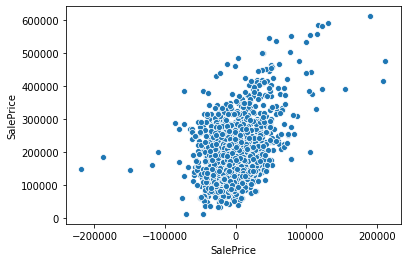

In [36]:
ax = sns.scatterplot(x=resids_lasso, y=y, palette='husl');


In [24]:
ss = StandardScaler()
X_sc = ss.fit_transform(new_train)
test_sc = ss.transform(new_test)
model = LinearRegression()
lasso = LassoCV(n_alphas=1000, cv=5)    
ridge = RidgeCV(cv=5)
model.fit(X_sc, y)
lasso.fit(X_sc, y)
ridge.fit(X_sc, y)
model_pred = model.predict(X_sc)
lasso_pred = lasso.predict(X_sc)
ridge_pred = ridge.predict(X_sc)
resids_lr_sc = y - model_pred
resids_lasso = y - lasso_pred
resids_ridge = y - ridge_pred

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  This is separate from the ipykernel package so we can avoid doing imports until


In [25]:
lasso.coef_ 

array([ -2514.89803055,     -0.        ,   6442.0768988 ,  -4658.44111884,
        28376.29088237, -32055.93603692,  -2603.33647107,    667.64521398,
         3630.28124437, -15220.04708546,  -2020.00803901,  25842.80652065,
         2905.88685046,  19701.36128916, -70673.35364573,  54133.87195693,
         6532.56422835,    678.06083511,    186.80598381,     -0.        ,
         4691.57958892,  34819.80177174,   6694.30253507,  -1410.35143474,
         1536.96365912,    -78.72908954,   1145.93781953,   2131.13716382,
           -0.        ])

In [26]:
coef_df = pd.DataFrame({'variables':new_train.columns})
coe = pd.DataFrame({'ß - Beta':lasso.coef_})
coef_df = pd.concat([coef_df, coe], axis=1)
values = pd.DataFrame(new_train, index=list(range(0,2049)), columns=coef_df['variables'])
values['SalePrice'] = Sale
values.head()

variables,MS SubClass,Overall Qual,Year Remod/Add,1st Flr SF,Gr Liv Area,Full Bath,TotRms AbvGrd,EXTerior,EX_Q,rich_hood,...,Qual*GLA*Lot,Area_rhood,EXTQUAL_GLA,MS Zoning_is_C (all),MS Zoning_is_FV,MS Zoning_is_I (all),MS Zoning_is_RH,MS Zoning_is_RL,MS Zoning_is_RM,SalePrice
0,60.0,6.0,2005.0,725.0,1479.0,2.0,6.0,7.31,12.5,2.0,...,119949858.0,2958.0,18487.5,False,False,False,False,True,False,130500
1,60.0,7.0,1997.0,913.0,2122.0,2.0,8.0,9.99,12.5,5.0,...,170702168.0,10610.0,26525.0,False,False,False,False,True,False,220000
2,20.0,5.0,2007.0,1057.0,1057.0,1.0,5.0,9.99,7.6,3.0,...,41867770.0,3171.0,8033.2,False,False,False,False,True,False,109000
3,60.0,5.0,2007.0,744.0,1444.0,2.0,7.0,9.99,7.6,10.0,...,70770440.0,14440.0,10974.4,False,False,False,False,True,False,174000
4,50.0,6.0,1993.0,831.0,1445.0,2.0,6.0,6.55,7.6,5.0,...,123417450.0,7225.0,10982.0,False,False,False,False,True,False,138500


In [27]:
coef_df.sort_values('ß - Beta', ascending=False)

,variables,ß - Beta
15,GLA_Bath,54133.871957
21,Area_rhood,34819.801772
4,Gr Liv Area,28376.290882
11,quality_sq_ft,25842.806521
13,GLA_OQ,19701.361289
22,EXTQUAL_GLA,6694.302535
16,GLA_Garage,6532.564228
2,Year Remod/Add,6442.076899
20,Qual*GLA*Lot,4691.579589
8,EX_Q,3630.281244


In [28]:
values.corr()[['SalePrice']].sort_values('SalePrice', ascending=False).head(77)

variables,SalePrice
variables,
SalePrice,1.000000
Area_rhood,0.838978
GLA_OQ,0.837232
EXTQUAL_GLA,0.823658
Overall Qual,0.800387
Qual_Liv_Gar,0.799014
quality_sq_ft,0.792121
GLA_Garage,0.757208
rich_hood,0.740977


In [ ]:
coef_df.head()
# coef_df.sort_values(by='coeffieients', ascending=False)

In [21]:
def metrics_summary(X, y, test_set, cv, k, scaled=True, poly=False, r_alpha=np.logspace(0, 5, 100), l_alpha=np.logspace(-3, 0, 100), log_y=True):
    
    if log_y:
        np.log(y)
        
    # Run polynomial features
    if poly:
        poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
        X = poly.fit_transform(new_train)
        test_set = poly.fit_transform(new_test)
    
    # Scaling our data
    ss = StandardScaler()
    X_sc = ss.fit_transform(X)
    test_sc = ss.transform(test_set)

    # Instantiating our models
    model = LinearRegression()
    lasso = LassoCV(alphas=l_alpha, max_iter=10_000, cv=5,)    
    ridge = RidgeCV(alphas=r_alpha, cv=5)

    # Fitting our models on non-scaled and scaled data
    model.fit(X,y)
    model.fit(X_sc, y)
    lasso.fit(X_sc, y)
    ridge.fit(X_sc, y)

    # Running the predictions on our model
    model_p = model.predict(X)
    model_pred = model.predict(X_sc)
    lasso_pred = lasso.predict(X_sc)
    ridge_pred = ridge.predict(X_sc)

    resids_lr = y - model_p
    resids_lr_sc = y - model_pred
    resids_lasso = y - lasso_pred
    resids_ridge = y - ridge_pred

    rss_lr = (resids_lr ** 2).sum()
    rss_lr_sc = (resids_lr_sc ** 2).sum()
    rss_lasso = (resids_lasso ** 2).sum()
    rss_ridge = (resids_ridge ** 2).sum()

    r_squared = (metrics.r2_score(y, model_p))
    adj_r2 = 1 - (1-r_squared)*((len(y)-1)/(len(y)-X.shape[k]-1))

    # Running cross value scores
    cvs = cross_val_score(model, X_sc, y, cv=cv).mean()
    cvs_l = cross_val_score(lasso, X_sc, y, cv=cv).mean()
    cvs_r = cross_val_score(ridge, X_sc, y, cv=cv).mean()

    print(f'RSS (Residual Sum of Squares) : {(rss_lr)}')
    print(f'MAE (Mean Absolute Error) : {(metrics.mean_absolute_error(y, model_p))}') 
    print(f'MSE (Mean Square Error) : {(metrics.mean_squared_error(y, model_p))}')
    print()
    print(f'Root MSE (Root Meen Square Error Linear Non-Scaled) : {(np.sqrt(rss_lr / len(model_p)))}')
    print(f'Root MSE (Root Meen Square Error Linear Scaled) : {(np.sqrt(rss_lr_sc / len(model_pred)))}')
    print(f'Root MSE (Root Meen Square Error Lasso) : {(np.sqrt(rss_lasso / len(lasso_pred)))}')
    print(f'Root MSE (Root Meen Square Error Ridge) : {(np.sqrt(rss_ridge / len(ridge_pred)))}')
    print()
    print(f'R\u00b2 : {(r_squared)}')
    print(f'Adjusted R\u00b2 : {(adj_r2)}')
    print()
    print(f'CVS (Cross Value Score LR) : {(cvs)}')
    print(f'CVS (Cross Value Score Lasso) : {(cvs_l)}')
    print(f'CVS (Cross Value Score Ridge) : {(cvs_r)}')

    model.fit(X_sc, y)
    model_pred_final = model.predict(test_sc)
    lasso.fit(X_sc, y)
    lasso_pred_final = lasso.predict(test_sc)
    ridge.fit(X_sc, y)
    ridge_pred_final = ridge.predict(test_sc)

    if (cvs > cvs_l) and (cvs > cvs_r):
        prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': model_pred_final}).to_csv('wd_prediction_last.csv', index=False)
    elif (cvs_l > cvs) and (cvs_l > cvs_r):
        prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': lasso_pred_final}).to_csv('wd_prediction_last.csv', index=False)
    elif (cvs_r > cvs_l) and (cvs_r > cvs):
        prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': ridge_pred_final}).to_csv('wd_prediction_last.csv', index=False)
    return prediction, ridge_pred_final, lasso_pred_final, model_pred_final


In [22]:
prediction, ridge, lasso, linear = metrics_summary(new_train, y, new_test, 5, 1, poly=False, log_y=True)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DataConversionWarning: Data with input dtype bool, int64, float64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


RSS (Residual Sum of Squares) : 1.3425034597929025e+27
MAE (Mean Absolute Error) : 412722423868.4776
MSE (Mean Square Error) : 6.548797364843427e+23

Root MSE (Root Meen Square Error Linear Non-Scaled) : 809246400353.0338
Root MSE (Root Meen Square Error Linear Scaled) : 27344.329195024115
Root MSE (Root Meen Square Error Lasso) : 27344.37715899604
Root MSE (Root Meen Square Error Ridge) : 27403.227253493904

R² : -104255655104770.03
Adjusted R² : -105752394707759.31

CVS (Cross Value Score LR) : 0.8675563743939778
CVS (Cross Value Score Lasso) : 0.8676477569576522
CVS (Cross Value Score Ridge) : 0.8691055355733086


In [ ]:
prediction = np.exp(ridge)

In [ ]:
prediction = np.exp(lasso)

In [ ]:
prediction = pd.DataFrame({'Id': test_id['Id'], 'SalePrice': prediction}).to_csv('wd_prediction_3.csv', index=False)


In [ ]:
prediction = np.exp(linear)

In [ ]:
feat_lasso = pd.DataFrame({'Feature': X_tr.columns, 'beta': lasso.coef_})